# Chief-deputy Rendezvous and Docking on an Elliptical Orbit
© 2023 Tomohiro Sasaki, All Rights Reserved.

## Import libraries

In [1]:
using Plots; gr()
using LinearAlgebra
using Revise
using CDDP # import CDDP module

using DifferentialEquations
using DataInterpolations
using BenchmarkTools
using Printf

## Define Simulation Setup

In [12]:
tf = 120000. # final time 
tN = 500 # number of time steps
dt = tf/tN # time step
hN = 50; # horizon length

## Define Dynamics Model

In [23]:
includet("../src/models/chiefdeputy.jl")
model = ChiefDeputy()

# initial state
x_init = model.x_init
@printf("Initial State: %s \n", x_init)

# final state
x_final = model.x_final
@printf("Final State: %s \n", x_final)

# model dimensions
nx, nu = model.dims.nx, model.dims.nu
@printf("nx: %i, nu: %i", nx, nu)

Initial State: [2.5, 0.0, 5.0, -0.01, -0.02, -0.01, 1.0] 
Final State: [2.5, 0.0, 5.0, -0.005, -0.01, -0.005, 0.99] 
nx: 7, nu: 3

## Propagate Chief Spacecraft Orbit

In [24]:
Œ, _ = initialize_trajectory(model, tf, tN, model.œ_init, model.fc!)
model.params.Œ = Œ;

In [15]:
Œ

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 2138-element Vector{Float64}:
      0.0
      0.008420024527190503
      0.09262026979909552
      0.7126881102764273
      3.839541097529362
      8.641713641343555
     14.177401229035855
     21.04958622506062
     28.830330502418022
     37.660414795836125
      ⋮
 119186.20755470078
 119284.67445912429
 119386.26460763854
 119491.1568423116
 119599.51233791854
 119711.44643759116
 119826.99062903642
 119946.04705860231
 120000.0
u: 2138-element Vector{Vector{Float64}}:
 [9.494477835790528e6, 3926.0787967853134, 6.865970128328228e10, 0.0, 0.17453292519943295, 1.5714453463008868]
 [9.494510893508682e6, 3926.08791515813, 6.865970128328228e10, 0.0, 0.17453291765335682, 1.5714517669997117]
 [9.49484147491258e6, 3926.1790865240505, 6.865970128328228e10, 0.0, 0.17453284219693424, 1.5715159715274822]
 [9.497276180306708e6, 3926.8497991913464, 6.865970128328228e10, 0.0, 0.17453228676331217, 1.5719886490658914]
 [

In [29]:
X0, U0 = initialize_trajectory(model, tf, hN, x_init, model.f!, X_ref=Œ);


(ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, ODEParameter, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, ODEParameter, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, ODEParameter, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, ODEParameter, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDi

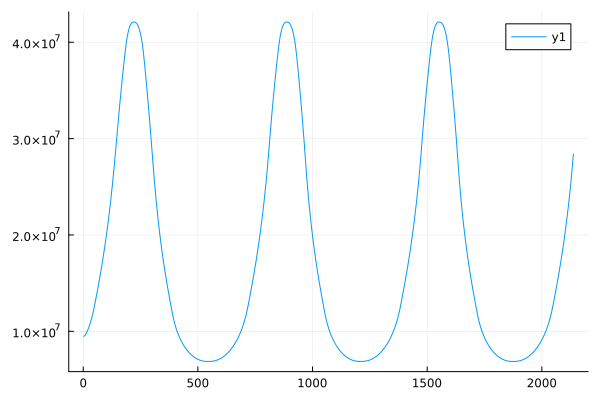

In [63]:
plot(Œ[1,:])

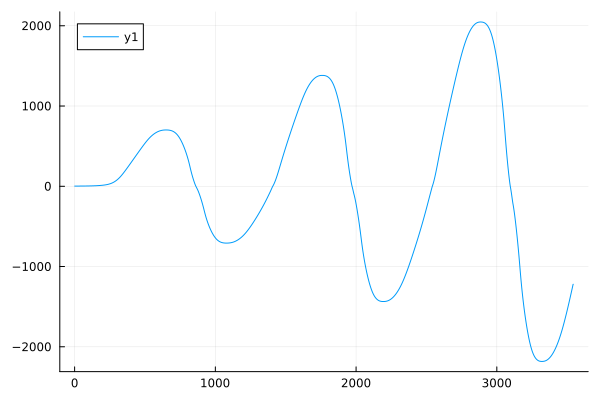

In [31]:
plot(X0[1,:])

## Define Cost Functions for Trajecotry Optimization

In [66]:
function ell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    Q = Diagonal([1.0e+0 * [0; 0; 0]; 1.0e+0 * [0; 0; 0]; [0.]])
    R = Diagonal(1e+2 * [1; 1; 1])
    if x_ref == nothing
        return x'*Q*x + u'*R*u
    else
        return (x-x_ref)'*Q*(x-x_ref) + u'*R*u
    end
end

function phi_cost(x::Vector; x_ref::Vector=nothing)
    Qf = Diagonal([1e+2 * [1; 1; 1]; 1e+2 * [1; 1; 1]; [0.]])
    if x_ref == nothing
        return x'*Qf*x
    else
        return (x-x_ref)'*Qf*(x-x_ref)
    end
end

function ∇ₓell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    Q = Diagonal([1.0e+0 * [0; 0; 0]; 1.0e+0 * [0; 0; 0]; [0.]])
    R = Diagonal(1e+2 * [1; 1; 1])
    if x_ref == nothing
        return Q*x
    else
        return Q*(x-x_ref)
    end
end

function ∇ᵤell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    Q = Diagonal([1.0e+0 * [0; 0; 0]; 1.0e+0 * [0; 0; 0]; [0.]])
    R = Diagonal(1e+2 * [1; 1; 1])
    return R*u
end

function ∇ₓₓell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    Q = Diagonal([1.0e+0 * [0; 0; 0]; 1.0e+0 * [0; 0; 0]; [0.]])
    R = Diagonal(1e+2 * [1; 1; 1])
    return Q
end

function ∇ᵤᵤell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    Q = Diagonal([1.0e+0 * [0; 0; 0]; 1.0e+0 * [0; 0; 0]; [0.]])
    R = Diagonal(1e+2 * [1; 1; 1])
    return R
end

function ∇ₓᵤell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    return zeros(6,3)
end

function ∇ₓphi_cost(x::Vector; x_ref::Vector=nothing)
    Qf = Diagonal([1e+2 * [1; 1; 1]; 1e+2 * [1; 1; 1]; [0.]])
    if x_ref == nothing
        return Qf*x
    else
        return Qf*(x-x_ref)
    end
end

function ∇ₓₓphi_cost(x::Vector; x_ref::Vector=nothing)
    Qf = Diagonal([1e+2 * [1; 1; 1]; 1e+2 * [1; 1; 1]; [0.]])
    return Qf
end


cost_funcs = CostFunction(
    ell=ell_cost,
    ∇ₓell=∇ₓell_cost,
    ∇ᵤell=∇ᵤell_cost,
    ∇ₓₓell=∇ₓₓell_cost,
    ∇ᵤᵤell=∇ᵤᵤell_cost,
    ∇ₓᵤell=∇ₓᵤell_cost,
    phi=phi_cost,
    ∇ₓphi=∇ₓphi_cost,
    ∇ₓₓphi=∇ₓₓphi_cost,
);

## Construct Trajecotry Optimization Problem

In [23]:


dyn_funcs = DynamicsFunction(f! =model.f!, ∇f=model.∇f, ∇²f=model.∇²f, integrator=Tsit5());

prob = DDPProblem(
    model=model, 
    tf=tf, 
    tN=tN, 
    dt=dt, 
    dims=model.dims,
    cost_funcs=cost_funcs,
    dyn_funcs=dyn_funcs,
    x_init=x_init, 
    x_final=x_final, 
    X_ref=X_ref)
    
sol = solve_ddp(
    prob, 
    X=nothing, 
    U=nothing, 
    isilqr=true,
    max_ite=100, 
    tol=1e-8,
    reg_param_x=1e-6, 
    reg_param_x_fact=10.0, 
    reg_param_x_lb=1e-20,
    reg_param_u=1e-4, 
    reg_param_u_fact=10.0,
    reg_param_u_lb=1e-20,
    line_search_steps = 5 .^ LinRange(0, -6, 30))
    
X, U, J, gains = sol.X, sol.U, sol.J, sol.gains;
X_ilqr, U_ilqr, J_ilqr, gains_ilqr = sol.X, sol.U, sol.J, sol.gains;

ErrorException: type ChiefDeputy has no field ∇f

## Solve Trajectory Optimization Problem


## Simulate MPPI Control

In [ ]:
# tN = model.tN
# dt = model.dt
# XEst = zeros(model.x_dim, tN+1)
# XTrue = zeros(model.x_dim, tN+1)
# U = zeros(model.u_dim, tN)
# u = zeros(model.u_dim)
# xEst = model.x_init
# xTrue = model.x_init
# PEst = Matrix{Float64}(I(model.x_dim))
# PEst_arr = zeros(model.x_dim, model.x_dim, tN+1)
# PEst_arr[:,:,1] = PEst

# XTrue[:,1] = xTrue
# XEst[:,1] = xEst

# hN = 50
# tf = hN * dt

# for k in axes(U,2)
#     X_arr = zeros(hN, model.x_dim)
#     X_cddp_arr = zeros(hN, model.x_dim)
#     U_cddp_arr = zeros(hN, model.u_dim)
#     for kk in 1:hN
#         t = (kk - 1) * dt + (k-1) * dt
#         X_arr[kk,:] = X_(t)

#         X_cddp_arr[kk,:] = X_cddp(t)
#         U_cddp_arr[kk,:] = U_cddp(t)
#     end
#     X_arr = Vector[X_arr[t, :] for t in axes(X_arr,1)]
#     X_cddp_arr = Vector[X_cddp_arr[t, :] for t in axes(X_cddp_arr,1)]
#     U_cddp_arr = Vector[U_cddp_arr[t, :] for t in axes(U_cddp_arr,1)]
#     X_ref = linear_interpolation((collect(LinRange(0.0, hN*dt, hN)),), X_arr, extrapolation_bc = Line())
#     X_cddp_ = linear_interpolation((collect(LinRange(0.0, hN*dt, hN)),), X_cddp_arr, extrapolation_bc = Line())
#     U_cddp_ = linear_interpolation((collect(LinRange(0.0, hN*dt, hN)),), U_cddp_arr, extrapolation_bc = Line())

#     prob = CDDPProblem(model, tf, hN, dt, x_dim, u_dim, λ_dim, ell_cost, phi_cost, model.f!, XEst[:,k], X_((k-1+hN)*dt), c, empty, X_ref);
    
#     PEst = PEst_arr[:,:,k]
#     # sol = solve_cddp(prob,max_ite=20, verbose=false); 
#     sol = solve_cddp(prob, X=X_cddp_, U=U_cddp_, reg_param1=1e-4,reg_param2=1e-2,μip=1e-6,max_ite=10, verbose=false); 
#     X, U, J, gains = sol.X, sol.U, sol.J, sol.gains;
#     u = U(0.)
#     p = ODEParams(prob.model, u, isarray=true)
#     XTrue[:,k+1] = XTrue[:,k] + rk4_step(prob.f!, XTrue[:,k], p, k*dt, h=dt) * dt
#     z = model.h!(zeros(3), XTrue[:,k], k*dt) + diagm(0.01*ones(3)).^2 * randn(3)
#     u_noised =  u + diagm(0.0001*ones(model.u_dim)).^2 * randn(model.u_dim)
#     XEst_, PEst_ = solve_EKF(model, kf_prob, XEst[:,k], u_noised, PEst_arr[:,:,k], z, t=k*dt)
#     XEst[:,k+1] = copy(XEst_)
#     PEst_arr[:,:,k+1] = copy(PEst_)

# end

# plot(XEst[2,:],XEst[1,:])
# plot!(XTrue[2,:],XTrue[1,:])

# Appendix
Obtain orbital elements of chief orbit


In [4]:
includet("../src/astro_funcs.jl")



In [70]:
μ = 3.986004415e+14
sidereal_day = 86164.0905  # s
r_cubed = μ  * sidereal_day^2 / (4 * pi^2)
Re = 6378e+3
ra = r_cubed ^ (1 / 3)
rp = 500e3 + Re
a = (ra + rp) / 2  # a (m) semi-major axis 
e = (ra - rp) / (ra + rp) # e eccentricity
i = 0.0 # i (rad) inclination
Ω = 10.0 * pi / 180 # Ω (rad) right ascension of ascending node
ω = 20.0 * pi / 180 # ω (rad) argument of perigee
M = 10.0 * pi / 180 # M (rad) mean anomaly
MOE = [
    a  
    e
    i
    Ω
    ω
    M
]

MOE = [46000e3; 0.67; deg2rad(62.8); deg2rad(0); deg2rad(0); deg2rad(0)]
œ_init = MOE2OE(MOE)
@printf("œ_init = %s\n", œ_init)

T_s = 2*pi*sqrt(MOE[1]^3/μ)
@printf("T_s = %s\n", T_s)

n = sqrt(μ/(a^3))
get_initial_y_velocity(500,n,MOE[2])
# T_m = T_s / 60 
# T_h = T_m / 60

# r_geo = 42164e+3
# r_leo = 700*10^3
# T_s = 2*pi*sqrt(r_geo^3/μ)
# T_m = T_s / 60
# T_h = T_m / 60

œ_init = [1.5179999999999998e7, 1.4733342674004238e-28, 1.0052243705904616e11, 1.096066770252439, 0.0, 5.545640604761183e-32]
T_s = 98185.58412771056


-0.8960071782694164